# Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder

#%% load UCI Adult dataset from downloaded zip folder
labels = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
          'marital-status', 'occupation', 'relationship', 'race', 'sex', 
          'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
          'income']

train_df = pd.read_csv('../input/uci-adult/adult.data', na_values='?', header=None, names=labels, skipinitialspace=True)
test_df = pd.read_csv('../input/uci-adult/adult.test', na_values='?', header=None, names=labels, skipinitialspace=True)
train_df.dropna(axis=0, how='any', inplace=True)
test_df.dropna(axis=0, how='any', inplace=True)

# keep a copy to compare with processed data
data = pd.concat([train_df, test_df], axis=0)

In [2]:
#%% analyse features
target = train_df.values[:,14] # change column index 0-14
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=<=50K, Count=22654, Percentage=75.108%
Class=>50K, Count=7508, Percentage=24.892%


In [3]:
#%% drop redundant column
train_df.drop(labels=['education'], axis=1, inplace=True)
test_df.drop(labels=['education'], axis=1, inplace=True)

In [4]:
#%% convert 'income' to integer
salary_map={'<=50K':0,'>50K':1}
salary_map2={'<=50K.':0,'>50K.':1}

train_df['income']=train_df['income'].map(salary_map).astype(int)
test_df['income']=test_df['income'].map(salary_map2).astype(int)

In [5]:
#%% process 'capital-gain' and 'capital-loss'
train_df.loc[(train_df['capital-gain'] > 0),'capital-gain'] = 1    #capital loss and gain has a lot of zero values 
train_df.loc[(train_df['capital-gain'] == 0 ,'capital-gain')]= 0

test_df.loc[(test_df['capital-gain'] > 0),'capital-gain'] = 1    #capital loss and gain has a lot of zero values 
test_df.loc[(test_df['capital-gain'] == 0 ,'capital-gain')]= 0

train_df.loc[(train_df['capital-loss'] > 0),'capital-loss'] = 1
train_df.loc[(train_df['capital-loss'] == 0 ,'capital-loss')]= 0

test_df.loc[(test_df['capital-loss'] > 0),'capital-loss'] = 1
test_df.loc[(test_df['capital-loss'] == 0 ,'capital-loss')]= 0

#%% convert object type data to integers
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        encoder = LabelEncoder()
        encoder.fit(train_df[col])
        train_df[col] = encoder.transform(train_df[col])
        encoder.fit(test_df[col])
        test_df[col] = encoder.transform(test_df[col])

In [6]:
#%% separate X and y
X_train = train_df.drop(['income'], axis=1).to_numpy()
y_train = train_df['income'].to_numpy()
X_test = test_df.drop(['income'], axis=1).to_numpy()
y_test = test_df['income'].to_numpy()

print(X_train.shape)
print(y_train.shape)

(30162, 13)
(30162,)


# Model: Logistic Regression

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#%% standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=1000)
model.fit(X_train, y_train)
print("Training accuracy: ", model.score(X_train, y_train))
print("Test accuracy: ", model.score(X_test, y_test))

Training accuracy:  0.8125124328625423
Test accuracy:  0.8133466135458167


In [9]:
#%% tune various hyperparameters using GridSearchCV()
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

# define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'max_iter': [100, 500, 1000]
}

In [10]:
# grid search for best hyperparameters with 5-fold cross-validation
model = LogisticRegression(solver='saga')
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2']})

In [11]:
# print the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1'}


In [12]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

# Extract relevant columns
param_cols = ['param_max_iter', 'param_C', 'param_penalty']
mean_test_score_col = 'mean_test_score'
std_test_score_col = 'std_test_score'

# Display average accuracy for each hyperparameter combination
print(results_df_sorted[param_cols + [mean_test_score_col] + [std_test_score_col]])

   param_max_iter param_C param_penalty  mean_test_score  std_test_score
53           1000   10000            l2         0.812380        0.003449
41           1000     100            l2         0.812380        0.003449
31            100      10            l2         0.812380        0.003449
33            500      10            l2         0.812380        0.003449
34           1000      10            l1         0.812380        0.003449
35           1000      10            l2         0.812380        0.003449
36            100     100            l1         0.812380        0.003449
37            100     100            l2         0.812380        0.003449
38            500     100            l1         0.812380        0.003449
39            500     100            l2         0.812380        0.003449
40           1000     100            l1         0.812380        0.003449
42            100    1000            l1         0.812380        0.003449
43            100    1000            l2         0.8

In [19]:
from sklearn.model_selection import KFold

# Hyperparameter values
C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
n = X_train.shape[0]

# Storing average validation accuracies for each bootsrap dataset
avg_train_accuracies, avg_val_accuracies = [[], []]

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for C in C_vals:
    train_accs, val_accs = [[], []]
    
    # Loop over folds
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Training
        model = LogisticRegression(penalty=best_params['penalty'], C=C, 
                                   solver='saga', max_iter=best_params['max_iter'])
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracies on the training and validation fold
        train_accs.append(model.score(X_train_fold, y_train_fold)) 
        val_accs.append(model.score(X_val_fold, y_val_fold))

    # Storing average training and validation accuracies for this C
    avg_train_accuracies.append(np.mean(train_accs)) 
    avg_val_accuracies.append(np.mean(val_accs))

In [20]:
results_df = pd.DataFrame({'C': C_vals,
                          'Avg. Training Acc.': avg_train_accuracies,
                          'Avg. Validation Acc.': avg_val_accuracies})

results_df.sort_values(by='Avg. Validation Acc.', ascending=False)

,C,Avg. Training Acc.,Avg. Validation Acc.
4,10.000,0.812289,0.812048
6,1000.000,0.812280,0.812048
7,10000.000,0.812289,0.812048
5,100.000,0.812305,0.812015
3,1.000,0.812247,0.811949
2,0.100,0.812156,0.811783
1,0.010,0.811485,0.811186
0,0.001,0.791343,0.791460


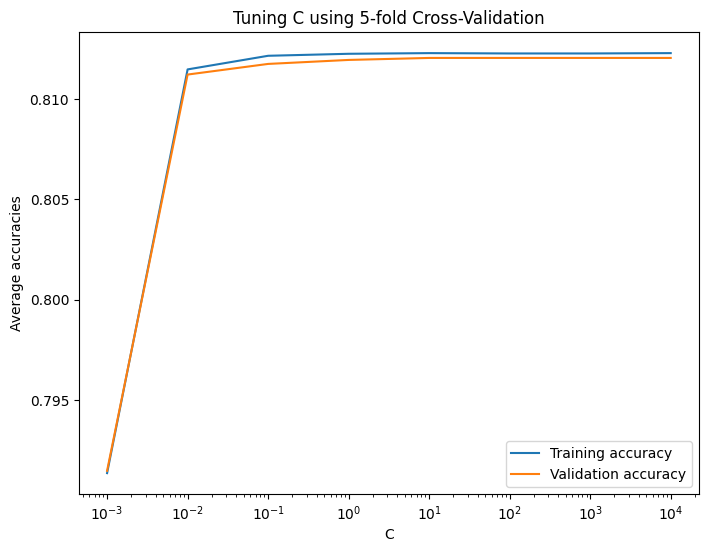

In [16]:
# Plot 
plt.figure(figsize=(8, 6))
plt.semilogx(C_vals, avg_train_accuracies, label='Training accuracy')
plt.semilogx(C_vals, avg_val_accuracies, label='Validation accuracy')
plt.xlabel(r'C')
plt.ylabel('Average accuracies')
plt.title('Tuning C using 5-fold Cross-Validation')
plt.legend(loc='lower right')

plt.savefig('LogReg_Adult_5-foldCV.pdf', bbox_inches='tight')

### No regularization

In [17]:
# Hyperparameter values
max_iters = [10, 50, 100, 300, 500, 750, 1000]
n = X_train.shape[0]

# Storing average validation accuracies for each bootsrap dataset
avg_train_accuracies, avg_val_accuracies = [[], []]

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for max_iter in max_iters:
    train_accs, val_accs = [[], []]
    
    # Loop over folds
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Training
        model = LogisticRegression(penalty=None, solver='saga', max_iter=max_iter)
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracies on the training and validation fold
        train_accs.append(model.score(X_train_fold, y_train_fold)) 
        val_accs.append(model.score(X_val_fold, y_val_fold))

    # Storing average training and validation accuracies for this C
    avg_train_accuracies.append(np.mean(train_accs)) 
    avg_val_accuracies.append(np.mean(val_accs))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


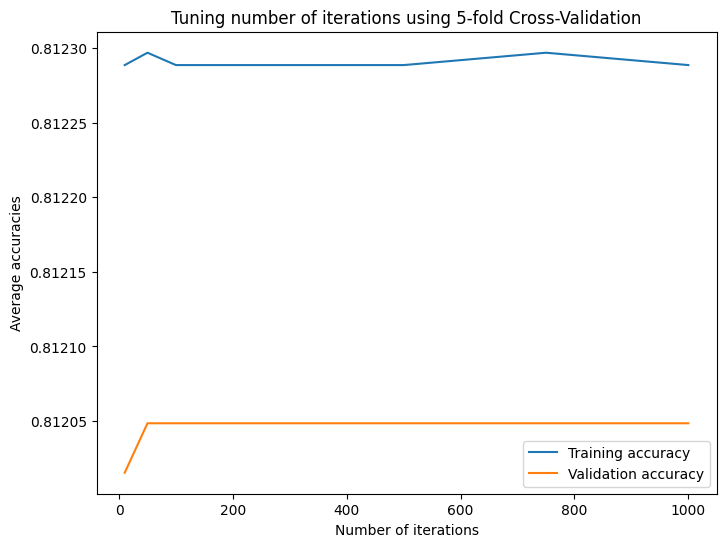

In [18]:
# Plot 
plt.figure(figsize=(8, 6))
plt.plot(max_iters, avg_train_accuracies, label='Training accuracy')
plt.plot(max_iters, avg_val_accuracies, label='Validation accuracy')
plt.xlabel('Number of iterations')
plt.ylabel('Average accuracies')
plt.title('Tuning number of iterations using 5-fold Cross-Validation')
plt.legend(loc='lower right')

plt.savefig('LogReg_Adult_5-foldCV_2.pdf', bbox_inches='tight')

# Bootstrap

In [21]:
# Number of bootstrap datasets
B = 300
n = X_train.shape[0]

# Storing average validation accuracies for each bootsrap dataset
bootstrap_accuracies = []

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for b in range(B):
    # Resampling with replacement
    indices = np.random.choice(n, n, replace=True)
    X_b = X_train[indices]
    y_b = y_train[indices]
    
    accuracies = []

    # Loop over folds
    for train_index, val_index in kf.split(X_b):
        X_train_fold, X_val_fold = X_b[train_index], X_b[val_index]
        y_train_fold, y_val_fold = y_b[train_index], y_b[val_index]

        # Training
        model = LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=100)
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracy on the validation fold
        accuracy = model.score(X_val_fold, y_val_fold)
        accuracies.append(accuracy)

    # Storing average validation accuracy for this bootstrap dataset
    avg_accuracy = np.mean(accuracies)
    print(f"Average validation accuracy for bootstrap dataset {b} = {avg_accuracy:.3f}")
    bootstrap_accuracies.append(avg_accuracy)

Average validation accuracy for bootstrap dataset 0 = 0.812
Average validation accuracy for bootstrap dataset 1 = 0.813
Average validation accuracy for bootstrap dataset 2 = 0.814
Average validation accuracy for bootstrap dataset 3 = 0.808
Average validation accuracy for bootstrap dataset 4 = 0.817
Average validation accuracy for bootstrap dataset 5 = 0.805
Average validation accuracy for bootstrap dataset 6 = 0.816
Average validation accuracy for bootstrap dataset 7 = 0.814
Average validation accuracy for bootstrap dataset 8 = 0.810
Average validation accuracy for bootstrap dataset 9 = 0.809
Average validation accuracy for bootstrap dataset 10 = 0.815
Average validation accuracy for bootstrap dataset 11 = 0.814
Average validation accuracy for bootstrap dataset 12 = 0.816
Average validation accuracy for bootstrap dataset 13 = 0.812
Average validation accuracy for bootstrap dataset 14 = 0.815
Average validation accuracy for bootstrap dataset 15 = 0.811
Average validation accuracy for bo

In [22]:
# Computing percentiles
mean_acc = np.mean(bootstrap_accuracies)
percentile_5 = np.percentile(bootstrap_accuracies, 5, axis=0)
percentile_95 = np.percentile(bootstrap_accuracies, 95, axis=0)

print("Mean: ", mean_acc)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)

Mean:  0.8120087231690483
5th percentile:  0.8084993974893172
95th percentile:  0.8157332507745859


In [23]:
print("Confidence interval: ", percentile_95 - percentile_5)

Confidence interval:  0.00723385328526871


# Final Evaluation

In [24]:
#%% final evaluation with best hyperparameters
model = LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=100)
model.fit(X_train, y_train)
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Training accuracy: 0.8125124328625423
Test accuracy: 0.8134130146082338


In [25]:
#%% 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

# make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print or use the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8134130146082338
Precision: 0.6775738228252195
Recall: 0.4589189189189189
F1 Score: 0.5472123751208507


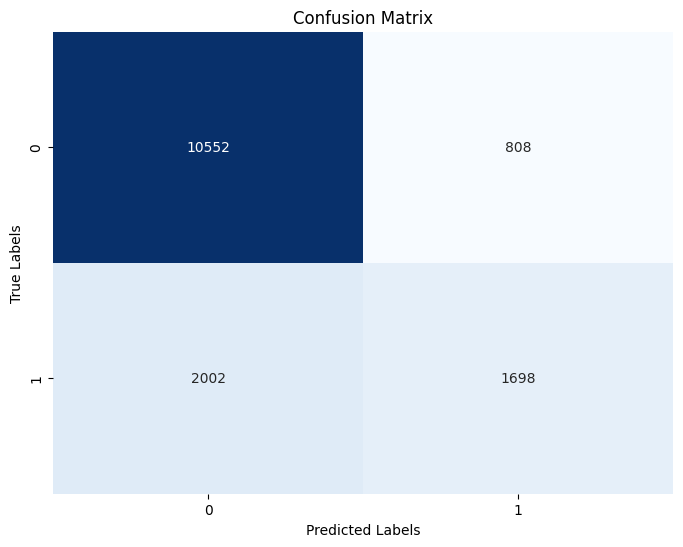

In [26]:
#%%
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig('LogReg_Adult_ConfMat.pdf', bbox_inches='tight')

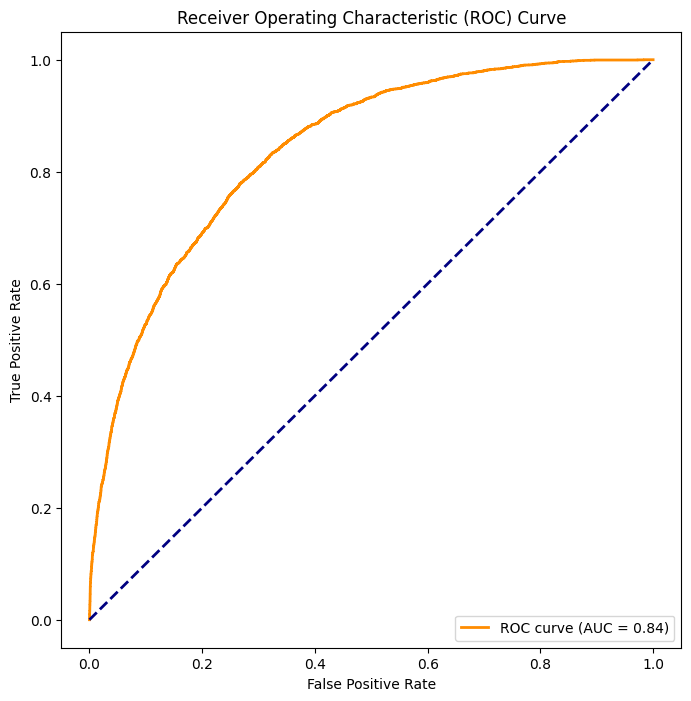

In [27]:
#%%
from sklearn.metrics import roc_curve, auc

# probability estimates for positive class
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig('LogReg_Adult_ROC-AUC.pdf', bbox_inches='tight')